In [39]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
%matplotlib inline

In [40]:
# Load in 2014 data
df = pd.read_csv('results2014.csv')

In [41]:
df.sample(10)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
25698,64.83,"Fonseca, Gregory A.",4877,163.90,M,35,282.73,29045,14358,NaN,...,25197,10.80,TX,198.27,32.08,136.70,129.48,USA,Austin,267.78
23147,65.53,"Kelley, Kacie A.",6059,172.82,F,27,316.37,26324,12556,NaN,...,28586,12.07,MA,217.87,32.08,143.07,135.60,USA,South Boston,301.40
19780,55.33,"Wallander, Celeste A.",855,144.37,F,52,258.05,22588,8863,NaN,...,21499,9.85,MD,176.33,27.23,120.45,114.08,USA,Bethesda,242.90
26354,47.95,"Heilbrun, Mark R.",881,-,M,51,210.87,29741,7368,NaN,...,9594,8.05,VA,-,22.87,-,-,USA,Fairfax Station,-
28927,58.55,"Formica, Amy",1629,148.60,F,40,262.68,32501,9270,NaN,...,22292,10.03,PA,182.10,29.30,124.72,118.37,USA,Butler,248.75
9187,43.35,"Bishop, Thomas W",1165,112.90,M,49,206.67,10522,6636,NaN,...,8267,7.88,TN,138.42,21.70,94.13,89.05,USA,Telford,193.95
28875,64.00,"Yu, Sharon L",315,169.18,F,61,343.07,32447,13446,NaN,...,30279,13.10,MA,217.35,31.18,139.75,132.05,USA,Haverhill,323.28
30268,55.60,"Oh, Dan",1445,150.62,M,59,284.35,33989,14445,NaN,...,25398,10.85,NJ,185.85,28.22,124.00,117.62,USA,Leonia,269.38
19521,53.63,"Clark, Brenda L",574,133.63,F,47,226.72,22299,4808,NaN,...,14386,8.65,MI,161.07,26.80,112.57,106.83,USA,Fairgrove,215.38
21756,55.60,"McMahon, Nicola J.",285,142.82,F,57,254.22,24808,8493,NaN,...,20838,9.70,CA,175.12,27.45,119.27,113.10,USA,Coronado,240.53


In [42]:
# Drop columns not related to race performance.
df = df.drop(columns=['name', 'bib', 'ctz', 'state', 'country', 'city'])

# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')

# Convert splits to numeric
splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k' ]
for split in splits:
    df[split] = pd.to_numeric(df[split])

# Binarize gender so 1 = female, 0 = male
df['gender'] = np.where(df['gender']=='F', 1, 0)

# Drop missing data
df = df.dropna()

In [43]:
df.dtypes

10k          float64
division       int64
25k          float64
gender         int64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
half         float64
20k          float64
40k          float64
dtype: object

In [59]:
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,0,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,1,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,0,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,1,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,0,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


In [44]:
# Split data into smaller set for memory reasons
from sklearn.model_selection import train_test_split
df1, df2 = train_test_split(df, test_size=0.90, random_state=42)

# Normalize smaller dataset
df1_norm = normalize(df1)

In [45]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [46]:
# Specify features - focus on splits every 10k and final time
X = df1.loc[:, ['10k', '20k', '30k', '40k', 'overall']]
X_norm = normalize(X)

## K Means

In [47]:
# Run k means model
for k in np.arange(2, 7, 1):
    model = KMeans(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.9490132196805277
K: 3, silhouette: 0.9046569578896213
K: 4, silhouette: 0.8676181730422375
K: 5, silhouette: 0.8072241470971726
K: 6, silhouette: 0.7894699301402841


## Mean Shift

In [48]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set bandwidth estimator
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Get labels, number of clusters, similarity score
labels = ms.labels_
n_clusters = len(np.unique(labels))
silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

K: 28, silhouette: 0.8208318952276669


## Spectral Clustering

In [49]:
from sklearn.cluster import SpectralClustering

# Run spectral clustering over range of k values
for k in np.arange(2, 4, 1):
    sc = SpectralClustering(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

# Memory error if run on higher k

K: 2, silhouette: 0.7894699301402841
K: 3, silhouette: 0.7894699301402841


## Affinity Propagation

In [50]:
from sklearn.cluster import AffinityPropagation

# Run and fit model
af = AffinityPropagation().fit(X_norm)

# Get number of clusters
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('K: {}'.format(n_clusters))

K: 1029


## K-Means

In [51]:
# PCA for plotting.  Reduce to 2 components
pca = PCA(n_components=2)
pca_X = pca.fit(X_norm).transform(X_norm)

# Get cluster assignments with k=2
model = KMeans(n_clusters=2, random_state=42).fit(X_norm)
labels = model.labels_
df1['cluster'] = labels

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


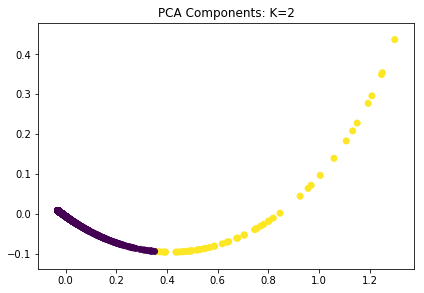

In [52]:
# Plot PCA components and clusters
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=df1['cluster'])
plt.tight_layout()
plt.title('PCA Components: K=2')
plt.show()

In [53]:
# Summary stats, overall time by cluster
df1.groupby(['cluster'])['overall'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3112.0,16400.417738,9093.401548,481.0,8366.75,16496.0,24471.75,31874.0
1,52.0,230.750000,127.684795,2.0,143.50,230.0,335.00,456.0


In [62]:
# Summary stats, gender distribution by cluster
df1.groupby(['cluster'])['gender'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3112.0,0.460797,0.498541,0.0,0.0,0.0,1.0,1.0
1,52.0,0.096154,0.297678,0.0,0.0,0.0,0.0,1.0


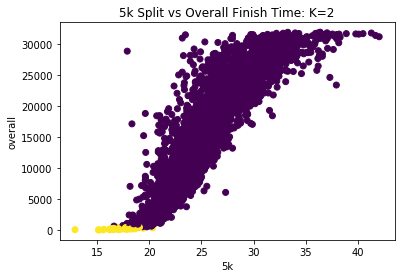

In [55]:
# Plot 5k split vs overall finish
plt.scatter(df1['5k'], df1['overall'], c=df1['cluster'])
plt.xlabel('5k')
plt.ylabel('overall')
plt.title('5k Split vs Overall Finish Time: K=2')
plt.show()

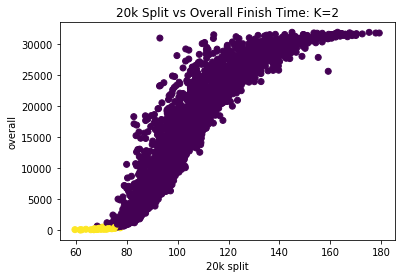

In [56]:
# Plot 20k split vs overall finish time
plt.scatter(df1['20k'], df1['overall'], c=df1['cluster'])
plt.xlabel('20k split')
plt.ylabel('overall')
plt.title('20k Split vs Overall Finish Time: K=2')
plt.show()

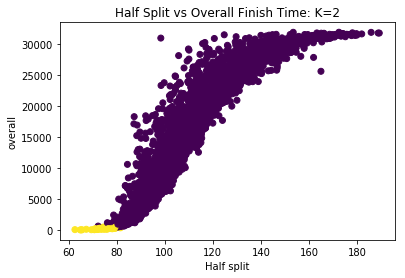

In [57]:
# Plot 'half' split vs overall finish time
plt.scatter(df1['half'], df1['overall'], c=df1['cluster'])
plt.xlabel('Half split')
plt.ylabel('overall')
plt.title('Half Split vs Overall Finish Time: K=2')
plt.show()

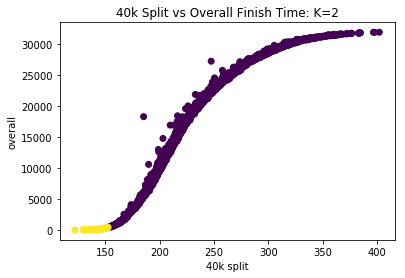

In [58]:
# Plot 40k split vs overall finish time
plt.scatter(df1['40k'], df1['overall'], c=df1['cluster'])
plt.xlabel('40k split')
plt.ylabel('overall')
plt.title('40k Split vs Overall Finish Time: K=2')
plt.show()


K Means with k=2 had the cleanest clusters.  k=3 starts to get messy and k=4 is even worse.

Majority of data contained in cluster 0

Cluster 0 has a much higher mean for overall time than cluster 1

Cluster 1 is predominantly men

Clustering appears to be identifying fastest runners only